In [7]:
import os
import numpy as np
import pickle
import time
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import metrics, svm
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_decision_regions
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

params = {'kernel_type': 'rbf',
          'test_size': 0.15,
          'subsample_size': (1000000-10),
          'sampling' : 'down',
          'pca' : False,
          'random_state': 123}

sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})


In [8]:
#--FASHION SCATTER FUNCTION
def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", 16))

    # create a scatter plot.
    f = plt.figure(figsize=(20, 20))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="b"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [9]:
#-- MAKE INPUTS AND OUTPUTS

nominal_converter = {'class': {"present" : 1, "absent" : 0}}

# read dataset and replace nominal with numerical data
df = pd.read_csv('BNG_heart-statlog.csv')
#convert nominal to numerical
df.replace(nominal_converter, inplace = True)


# nov 26th
# split into inputs and outputs
features = df.iloc[:params['subsample_size'], :-1]
labels = df['class'][:params['subsample_size']]

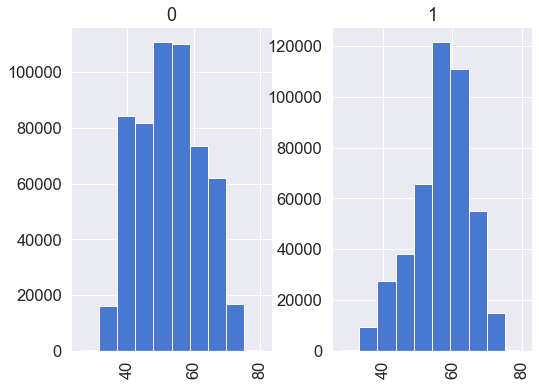

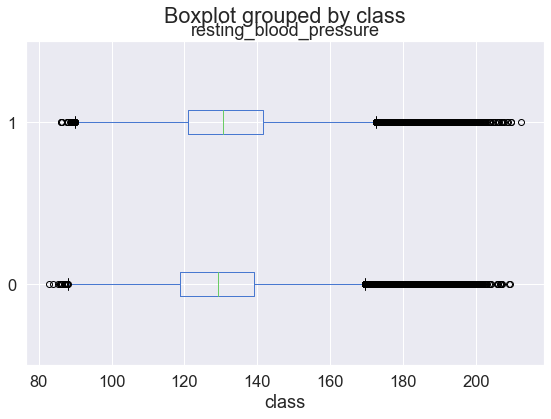

In [10]:
#-- HISTOGRAMS AND PLOTS

fig = plt.figure(figsize = (8,6))
plt.title('Age of patients grouped by class')
df.hist(ax=fig.gca(),  column="age", by="class")
plt.show()

fig = plt.figure(figsize = (9,6))
plt.title('Resting blood pressure of patients grouped by class')
df.boxplot(ax=fig.gca(),column="resting_blood_pressure", by="class", vert=False)
plt.show()

In [11]:
'''from sklearn.manifold import TSNE
import time

time_start = time.time()
tsne_file = 'tsne_' + str(subsection) + '.pickle'

if (not os.path.exists(tsne_file)):
    print('Creating TSNE File')
    tSNE = TSNE(random_state=123).fit_transform(features)
    
    with open(tsne_file, 'wb+') as output_file:
        pickle.dump(tSNE, output_file)
else:
    print('Loading from TSNE File')
    with open(tsne_file, 'rb') as input_file:
        tSNE = pickle.load(input_file)
        
print ('Time elapsed: {} seconds'.format(time.time()-time_start))

fashion_scatter(tSNE, np.multiply(np.array(labels), 4))'''

"from sklearn.manifold import TSNE\nimport time\n\ntime_start = time.time()\ntsne_file = 'tsne_' + str(subsection) + '.pickle'\n\nif (not os.path.exists(tsne_file)):\n    print('Creating TSNE File')\n    tSNE = TSNE(random_state=123).fit_transform(features)\n    \n    with open(tsne_file, 'wb+') as output_file:\n        pickle.dump(tSNE, output_file)\nelse:\n    print('Loading from TSNE File')\n    with open(tsne_file, 'rb') as input_file:\n        tSNE = pickle.load(input_file)\n        \nprint ('Time elapsed: {} seconds'.format(time.time()-time_start))\n\nfashion_scatter(tSNE, np.multiply(np.array(labels), 4))"

In [12]:
#-- Apply resampling
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

print('distribution before balancing', sorted(Counter(labels).items()))

time_start = time.time()

under_sampler = RandomUnderSampler(random_state=0)
features_downsampled, labels_downsampled = under_sampler.fit_resample(features, labels)
print('distribution after undersampling', sorted(Counter(labels_downsampled).items()))

features_upsampled, labels_upsampled = SMOTE().fit_resample(features, labels)
print('distribution after oversampling', sorted(Counter(labels_upsampled).items()))

print ('Time elapsed: {} seconds'.format(time.time()-time_start))

features_resampled, labels_resampled = (features_upsampled, labels_upsampled) \
if params['sampling'] == 'up' \
else (features_downsampled, labels_downsampled)


distribution before balancing [(0, 555941), (1, 444049)]
distribution after undersampling [(0, 444049), (1, 444049)]
distribution after oversampling [(0, 555941), (1, 555941)]
Time elapsed: 62.53805637359619 seconds


pca shape (888098, 4)
PCA done! Time elapsed: 4.605265855789185 seconds
[0.73849383 0.15069378 0.08820597 0.02022716]


Text(0, 0.5, 'Second Principal Component')

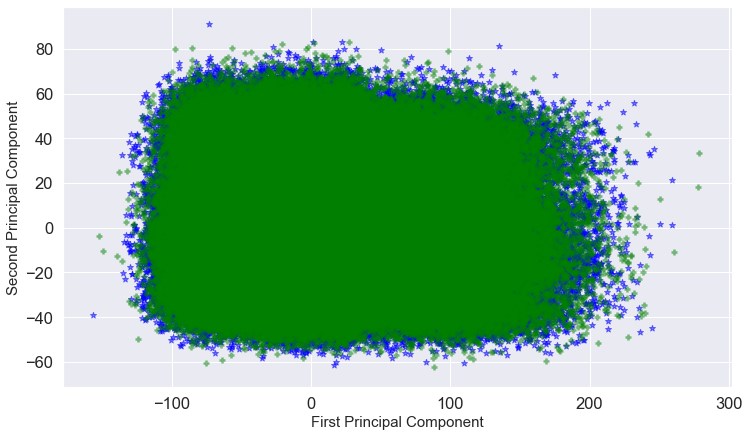

In [13]:
#-- PCA
time_start = time.time()
pca = PCA(n_components=4)
pca_intermediate = pca.fit(features_resampled)
pca_result = pca_intermediate.transform(features_resampled)
print('pca shape', pca_result.shape)
print ('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))


pca_df = pd.DataFrame()
pca_df['pc1'] = pca_result[:, 0]
pca_df['pc2'] = pca_result[:, 1]
pca_df['pc3'] = pca_result[:, 2]
pca_df['pc4'] = pca_result[:, 3]
print(pca.explained_variance_ratio_)

colordict = {0:'blue', 1:'green'}
piclabel = {0:'Absent', 1:'Present'}
markers = {0:'*', 1:'+'}
alphas = {0:0.5, 1:0.5}

fig = plt.figure(figsize=(12, 7))
plt.subplot(1,1,1)
for l in np.unique(labels):
    ix = np.where(labels==l)[0]
    plt.scatter(pca_df['pc1'][ix], pca_df['pc2'][ix], c=colordict[l],
               label=piclabel[l], s=40, marker=markers[l], alpha=alphas[l])
    
plt.xlabel("First Principal Component", fontsize=15)
plt.ylabel("Second Principal Component", fontsize=15)

In [14]:
# apply tSNE to the Principal Components
'''time_start = time.time()
pca_tSNE = TSNE(random_state=123).fit_transform(pca_result)
print ('Time elapsed: {} seconds'.format(time.time()-time_start))

fashion_scatter(pca_tSNE, np.multiply(np.array(labels), 4))'''
#-- SAVE MODEL
'''
time_start = time.time()

# make model if not exists, load if does
if (not os.path.exists(model_file)):
    print('Creating Model')
    model = svm.SVC(kernel=params['kernel_type'])

    model.fit(train_features, train_labels)

    with open(model_file, 'wb+') as output_file:
        pickle.dump(model, output_file)
else:
    print('Loading Model from File')
    with open(model_file, 'rb') as input_file:
        model = pickle.load(input_file)

print ('Fitting done, time: {} seconds'.format(time.time() - time_start))
'''


"\ntime_start = time.time()\n\n# make model if not exists, load if does\nif (not os.path.exists(model_file)):\n    print('Creating Model')\n    model = svm.SVC(kernel=params['kernel_type'])\n\n    model.fit(train_features, train_labels)\n\n    with open(model_file, 'wb+') as output_file:\n        pickle.dump(model, output_file)\nelse:\n    print('Loading Model from File')\n    with open(model_file, 'rb') as input_file:\n        model = pickle.load(input_file)\n\nprint ('Fitting done, time: {} seconds'.format(time.time() - time_start))\n"

In [15]:
#-- TRAIN-VAL SPLIT
if params['pca']:
    train_features, test_features, train_labels, test_labels = train_test_split(pca_result,
                                                                                labels_resampled,
                                                                                test_size=params['test_size'],
                                                                                random_state=params['random_state'])

else:
    train_features, test_features, train_labels, test_labels = train_test_split(features_resampled,
                                                                                labels_resampled,
                                                                                test_size=params['test_size'],
                                                                                random_state=params['random_state'])


model_file = 'svm_model_' + str(params['subsample_size']) + \
    '_pca' if params['pca'] else '_no_pca' + \
    '.pickle'


In [16]:
'''#-- PIPELINE

details = "Sample size {}, With the larger dataset, we saw that the model overfit to the majority class. We can try and tackle this with some balancing and some different polynomial degrees".format(len(train_labels) + len(test_labels))
print(details,'\n', params)

time_start = time.time()

model_1 = svm.SVC(gamma="scale")
pipe_steps = [('SVM', model_1)]

pipeline = Pipeline(pipe_steps, verbose=True)

search_space = {'kernel': ['rbf', 'poly'],
                'degree': [2, 4, 5],
                'C':[150, 200],
                'max_iter' : [10000, 12500]
               }

cross_val_grid = GridSearchCV(model_1, search_space, cv=4)
cross_val_grid.fit(train_features, train_labels)
cv_results = pd.DataFrame(cross_val_grid.cv_results_)

print('DONE pipeline training! took {} seconds'.format(time.time() - time_start))'''

'#-- PIPELINE\n\ndetails = "Sample size {}, With the larger dataset, we saw that the model overfit to the majority class. We can try and tackle this with some balancing and some different polynomial degrees".format(len(train_labels) + len(test_labels))\nprint(details,\'\n\', params)\n\ntime_start = time.time()\n\nmodel_1 = svm.SVC(gamma="scale")\npipe_steps = [(\'SVM\', model_1)]\n\npipeline = Pipeline(pipe_steps, verbose=True)\n\nsearch_space = {\'kernel\': [\'rbf\', \'poly\'],\n                \'degree\': [2, 4, 5],\n                \'C\':[150, 200],\n                \'max_iter\' : [10000, 12500]\n               }\n\ncross_val_grid = GridSearchCV(model_1, search_space, cv=4)\ncross_val_grid.fit(train_features, train_labels)\ncv_results = pd.DataFrame(cross_val_grid.cv_results_)\n\nprint(\'DONE pipeline training! took {} seconds\'.format(time.time() - time_start))'

In [17]:
ranked = cv_results.sort_values(['rank_test_score'])
display(ranked.iloc[:5, np.r_[0:3, 7:ranked.shape[1]]])

NameError: name 'cv_results' is not defined

In [18]:
optimized_svc = cross_val_grid.best_estimator_
predictions = optimized_svc.predict(test_features)

# make matrix
confusion_mat = confusion_matrix(test_labels, predictions)

print("Accuracy:", metrics.accuracy_score(test_labels, predictions))
print("Precision:", metrics.precision_score(test_labels, predictions))
print("Recall:", metrics.recall_score(test_labels, predictions))
print(details)

fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(confusion_mat.T,
            square=True,
            annot=True,
            fmt='d',
            cbar=False,
            linewidths=.5,
            xticklabels=["Absent", "Present"],
            yticklabels=["Absent", "Present"],
            ax=ax)

plt.xlabel('True Value');plt.ylabel('Predicted Value')
plt.title('Confusion Matrix of SVM predictions')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

NameError: name 'cross_val_grid' is not defined

In [130]:
#  Random Forest Comparison
from sklearn.ensemble import RandomForestClassifier

time_start = time.time()

forest = RandomForestClassifier()
search_space = {'n_estimators': [500],
                'max_leaf_nodes': [None],
                'max_depth':[16]
               }

forest_cv_grid = GridSearchCV(forest, search_space, cv=4)
forest_cv_grid.fit(train_features, train_labels)

forest = forest_cv_grid.best_estimator_
forest.fit(train_features, train_labels)
print('DONE Forest training! took {} seconds'.format(time.time() - time_start))

forest_predictions = forest.predict(test_features)


DONE Forest training! took 8018.922192811966 seconds


In [131]:
forest_results = pd.DataFrame(forest_cv_grid.cv_results_)
ranked = forest_results.sort_values(['rank_test_score'])
display(ranked[:5])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaf_nodes,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,1131.073169,27.25878,42.052197,0.772673,16,None,500,"{'max_depth': 16, 'max_leaf_nodes': None, 'n_e...",0.898474,0.899439,0.898353,0.899089,0.898839,0.000445,1


Started random forest classification attempt with:
{'kernel_type': 'rbf', 'test_size': 0.15, 'subsample_size': 999990, 'sampling': 'down', 'pca': False, 'random_state': 123}

Because going from 500 -> 1000 estimators made no noticeable difference except for doubling training time. Moving to full dataset with 16 max depth and no max leaf nodes.
              precision    recall  f1-score   support

           0       0.90      0.90      0.90     66490
           1       0.90      0.90      0.90     66725

    accuracy                           0.90    133215
   macro avg       0.90      0.90      0.90    133215
weighted avg       0.90      0.90      0.90    133215



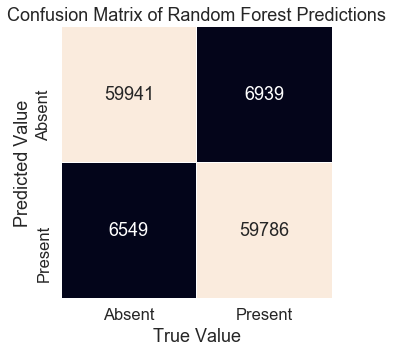

In [132]:
# Metrics for Random Forest
print("Started random forest classification attempt with:")
print(params)
print("\nBecause going from 500 -> 1000 estimators made no noticeable difference except for doubling training time, we are moving to full dataset with 16 max depth and no max leaf nodes.")
print(metrics.classification_report(test_labels, forest_predictions))

confusion_mat = confusion_matrix(test_labels, forest_predictions)

fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(confusion_mat.T,
            square=True,
            annot=True,
            fmt='d',
            cbar=False,
            linewidths=.5,
            xticklabels=["Absent", "Present"],
            yticklabels=["Absent", "Present"],
            ax=ax)

plt.xlabel('True Value');plt.ylabel('Predicted Value')
plt.title('Confusion Matrix of Random Forest Predictions')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [30]:
if params['subsample_size'] < 10000:
    with open('final_forest_model.pickle', 'wb+') as output_file:
        pickle.dump(forest, output_file)
    print('wrote final model to file')
    
else:
    with open('C:/Users/augus/Documents/AI/datasets/Heart_Statlog/final_forest_model.pickle', 'rb') as input_file:
        forest = pickle.load(input_file)
    print("loaded final model from file")

loaded final model from file


In [32]:
last_features = df.iloc[params['subsample_size']:, :-1]
last_labels = df['class'][params['subsample_size']:]
d = list(zip(forest.predict(last_features), last_labels))
final_prediction_sample_df = pd.DataFrame(d, columns = ['Predicted','Ground Truth'])
print("Predictions for the Last 10 Points in the Dataset")
display(final_prediction_sample_df)

Predictions for the Last 10 Points in the Dataset


,Predicted,Ground Truth
0,1,1
1,1,0
2,1,1
3,0,0
4,0,0
5,0,0
6,1,1
7,1,1
8,0,0
9,1,1


In [70]:
rand = np.r_[10, 500000, 1500, 999999, 4, 12031, 71000, 69, 420, 600411]
rand_features = df.iloc[rand, :-1]
rand_labels = df['class'][rand]
display(pd.concat([rand_features, rand_labels], axis=1, join='inner'))

,age,sex,chest,resting_blood_pressure,serum_cholestoral,fasting_blood_sugar,resting_electrocardiographic_results,maximum_heart_rate_achieved,exercise_induced_angina,oldpeak,slope,number_of_major_vessels,thal,class
10,51.462914,1,4.000000,157.724738,198.125241,0,0,135.630633,1,0.846988,2,0,3,0
500000,51.614472,1,4.000000,118.459780,183.417942,1,0,161.874523,1,2.775869,2,0,7,1
1500,60.788770,0,2.242885,106.158762,312.241243,0,0,132.188519,0,0.309381,2,1,3,0
999999,58.272584,1,2.137128,164.602143,268.305077,0,2,136.629945,0,3.389164,3,1,3,1
4,58.805677,1,3.000000,121.035286,257.257441,0,0,145.333117,0,1.212600,3,0,7,0
12031,58.266732,1,4.000000,164.440977,275.260542,1,2,159.418825,0,1.774102,2,3,3,1
71000,39.814736,1,3.000000,137.738904,183.016036,0,2,188.320226,0,0.000000,1,1,6,0
69,44.851372,1,1.658455,128.392899,218.362071,0,0,146.026896,0,4.248760,3,1,7,1
420,39.407508,1,4.000000,111.891143,207.267213,0,2,152.174106,1,3.957284,3,1,7,1
600411,60.534258,1,4.000000,149.432076,231.747155,0,2,163.179777,1,2.568356,2,0,7,1


In [71]:
d_rand = list(zip(forest.predict(rand_features), rand_labels))
rand_df = pd.DataFrame(d_rand, columns = ['Predicted','Ground Truth'])
print("Predictions for a random 10 Points in the Dataset")
display(rand_df)

Predictions for a random 10 Points in the Dataset


,Predicted,Ground Truth
0,1,0
1,1,1
2,0,0
3,1,1
4,1,0
5,1,1
6,0,0
7,1,1
8,1,1
9,1,1
